<a href="https://colab.research.google.com/github/batmanvane/complex-systems-modeling/blob/main/notebooks/05_Wind_Turbine_Tower_Harmonic_Excitation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Continuous-Time Dynamical System - A worked Modeling Example: Wind Turbine Tower — Tower-Shadow Harmonic Excitation (1-DoF Model)


**How to use this notebook**
- Run cells top-to-bottom.
- Adjust parameters (mass, damping ratio, natural frequency, number of blades, rotor rpm, etc.).
- Explore steady-state and time-domain responses.
- All plots use Matplotlib with one chart per figure.



## Modeling Goal

We model lateral vibration of a wind-turbine tower (treated as a single degree of freedom) excited by periodic aerodynamic loads when blades pass the tower's wind shadow.

**State/output:** top displacement $x(t)$  
**Input:** harmonic force $F(t) = F_0\,\sin(\Omega t)$  
**Model:** mass–spring–damper (first lateral bending mode)  



## From Physics to Differential Equation

**Mass–spring–damper model:**
$$
m\,\ddot{x}(t) + c\,\dot{x}(t) + k\,x(t) = F_0\,\sin(\Omega t)
$$

**Parameters (modal form):**
$$
\omega_n = \sqrt{\tfrac{k}{m}},\quad
\zeta = \tfrac{c}{2\sqrt{km}}
$$

**State-space (optional):**
$$
\dot{x}_1 = x_2,\quad
\dot{x}_2 = -2\zeta\omega_n x_2 - \omega_n^2 x_1 + \tfrac{F_0}{m}\sin(\Omega t)
$$



## Blade-Passing Excitation

Blade-passing frequency (BPF) sets the forcing frequency $\Omega$:
$$
\Omega = N_b\,\omega_r,\quad
\omega_r = \tfrac{2\pi\,n_{\mathrm{rpm}}}{60},\quad
f_{\mathrm{BPF}} = \tfrac{\Omega}{2\pi}
$$

where $N_b$ is the number of blades and $n_{\mathrm{rpm}}$ is rotor speed in rpm.


In [1]:

# === Parameters (feel free to modify) ===

# Structural (modal) parameters
m = 3.5e5         # modal mass [kg]
zeta = 0.02       # damping ratio [-]
omega_n = 5.5     # natural angular frequency [rad/s] (~0.875 Hz)
# Compute k and c from (m, zeta, omega_n)
k = m * omega_n**2
c = 2 * zeta * (k * m) ** 0.5

# Excitation (tower shadow) parameters
N_b = 3           # number of blades
rpm = 15.0        # rotor speed [rpm]
F0_over_k = 0.02  # static deflection under force amplitude: F0/k [m]
F0 = F0_over_k * k

# Time-domain simulation settings
t_end = 180.0     # total simulation time [s]
dt = 0.002        # time step [s]
x0 = 0.0          # initial displacement [m]
v0 = 0.0          # initial velocity [m/s]

# Computed excitation frequency
import numpy as np
omega_r = 2.0 * np.pi * rpm / 60.0          # rad/s
Omega = N_b * omega_r                        # rad/s
f_bpf = Omega / (2.0 * np.pi)                # Hz

omega_n, zeta, f_bpf, Omega


(5.5, 0.02, 0.7499999999999999, 4.712388980384689)


## Steady-State Harmonic Response (Amplitude & Phase)

For $x(t) = X\,\sin(\Omega t - \phi)$, the steady-state amplitude is
$$
X(\Omega) = \frac{F_0/k}{\sqrt{\big(1 - (\tfrac{\Omega}{\omega_n})^2\big)^2 + \big(2\zeta\tfrac{\Omega}{\omega_n}\big)^2}}
$$

and the phase lag is
$$
\phi(\Omega) = \tan^{-1}\!\left(\frac{2\zeta\,\Omega/\omega_n}{\,1 - (\Omega/\omega_n)^2}\right).
$$


In [2]:

def steady_state_amplitude(F0_over_k, Omega, omega_n, zeta):
    r = Omega / omega_n
    denom = np.sqrt((1.0 - r**2)**2 + (2.0 * zeta * r)**2)
    return F0_over_k / denom

def steady_state_phase(Omega, omega_n, zeta):
    r = Omega / omega_n
    return np.arctan2(2.0 * zeta * r, 1.0 - r**2)

X = steady_state_amplitude(F0_over_k, Omega, omega_n, zeta)
phi = steady_state_phase(Omega, omega_n, zeta)

X, phi


(np.float64(0.07459992699359913), np.float64(0.12818488981164095))


## Resonance Insight: Amplitude vs Rotor Speed

We sweep rotor speed to see how $X$ changes and to identify resonance risk.


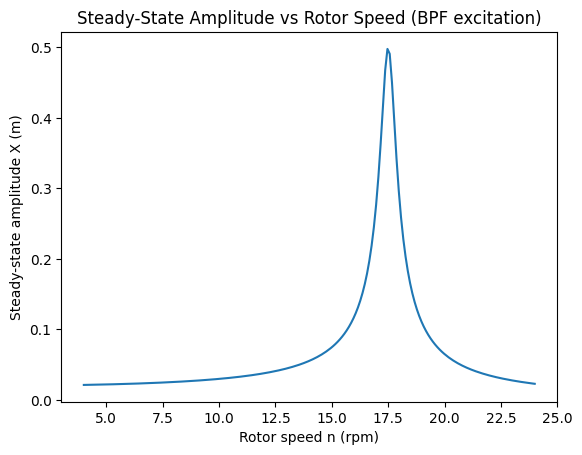

In [3]:

# Sweep rpm values
rpm_vals = np.linspace(4.0, 24.0, 200)
Omega_vals = 2.0 * np.pi * rpm_vals / 60.0 * N_b
X_vals = np.array([steady_state_amplitude(F0_over_k, Om, omega_n, zeta) for Om in Omega_vals])

# Plot: amplitude vs rpm
import matplotlib.pyplot as plt
plt.figure()
plt.plot(rpm_vals, X_vals)
plt.xlabel('Rotor speed n (rpm)')
plt.ylabel('Steady-state amplitude X (m)')
plt.title('Steady-State Amplitude vs Rotor Speed (BPF excitation)')
plt.show()



## Time-Domain Simulation (Explicit Integration)

We integrate
$$
m\,\ddot{x} + c\,\dot{x} + kx = F_0\sin(\Omega t)
$$
with explicit Euler (small $\Delta t$). For teaching purposes this is fine; for production use, prefer better ODE solvers.


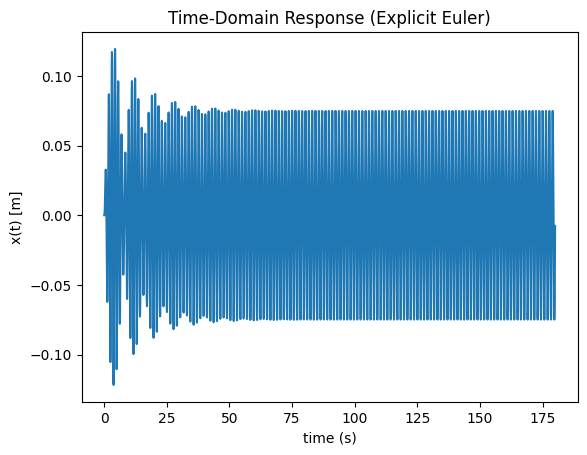

In [4]:

# Time vector
t = np.arange(0.0, t_end + dt, dt)
x = np.zeros_like(t)
v = np.zeros_like(t)

# Initial conditions
x[0] = x0
v[0] = v0

# Explicit Euler integration
for i in range(len(t) - 1):
    force = F0 * np.sin(Omega * t[i])
    a = (force - c * v[i] - k * x[i]) / m
    v[i+1] = v[i] + dt * a
    x[i+1] = x[i] + dt * v[i]

# Plot displacement vs time
plt.figure()
plt.plot(t, x)
plt.xlabel('time (s)')
plt.ylabel('x(t) [m]')
plt.title('Time-Domain Response (Explicit Euler)')
plt.show()



## Compare Time-Domain and Theory

We estimate the steady-state amplitude from the tail of the time series and compare to $X(\Omega)$.


In [5]:

# Estimate amplitude from the last segment of the simulation
tail_frac = 0.25  # use last 25% of samples
start_idx = int((1.0 - tail_frac) * len(x))
x_tail = x[start_idx:]

estimated_amp = 0.5 * (np.max(x_tail) - np.min(x_tail))
theory_amp = X

estimated_amp, theory_amp


(np.float64(0.0748573810990855), np.float64(0.07459992699359913))


## Modeling Checklist & Engineering Actions

1. **Define** outputs and use cases: tower-top $x(t)$, vibration limits.  
2. **Choose** model: 1-DoF mass–spring–damper (first bending mode).  
3. **Idealize**: small motion, linear, harmonic input via BPF.  
4. **Parameterize**: $\omega_n, \zeta$ from tests/design; $m$ from modal mass.  
5. **Relate excitation**: $\Omega = N_b \omega_r$; estimate $F_0$ from aero loads.  
6. **Analyze**: use $X(\Omega)$ to find resonance margins.  
7. **Decide mitigations**: detune $\omega_n$, increase damping $\zeta$, avoid critical rpm ranges.  
